In [ ]:
import sys 
sys.path.append(r'/Users/kostastsampourakis/Desktop/code/Python/projects/neuralssm/src/neuralssm')
from jax import numpy as jnp # type: ignore
from jax import random as jr # type: ignore
from jax.scipy.special import factorial as fac # type: ignore
from dynamax.utils.bijectors import RealToPSDBijector # type: ignore
from ssm import SPN
from parameters import sample_ssm_params, initialize
import tensorflow_probability.substrates.jax.distributions as tfd # type: ignore
import tensorflow_probability.substrates.jax.bijectors as tfb # type: ignore

import scienceplots # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib_inline # type: ignore
plt.style.use(['science', 'ieee'])
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## SSM form

In [3]:
# Initialize model and simulate dataset

## Define SSM parameters
### Lotka-Volterra model params
state_dim = 2
emission_dim = 1
input_dim = 0
num_reactions = 4   
initial_mean = 1.0 * jnp.array([50, 100]) #100 * jnp.ones(state_dim)
initial_covariance = jnp.eye(state_dim) * 5.0
pre = jnp.array([
    [1, 1],
    [1, 0],
    [0, 1],
    [1, 1]
])
post = jnp.array([
    [2, 0],
    [0, 0],
    [0, 2],
    [1, 0]
])
log_rates = 1 * jnp.array([jnp.log(0.01), jnp.log(0.5), jnp.log(1), jnp.log(0.01)])

emission_covariance = jnp.eye(emission_dim) * 1e2
# Initialize params and props
log_rates_dist = tfd.MultivariateNormalDiag(loc=log_rates, scale_diag=0.1*jnp.ones(num_reactions))
initial_distribution = tfd.MultivariateNormalFullCovariance(loc=initial_mean, covariance_matrix=initial_covariance)

In [4]:
param_names = [['mean', 'cov'],
               ['pre', 'post', 'log_rates'],
               ['cov']]
prior_fields = [[initial_mean, initial_covariance],
                [pre, post, log_rates],
                [emission_covariance]]
is_constrained_tree = [[True, True], 
                       [True, True, False], 
                       [True]]
constrainers  = [[None, None],
                [None, None, tfb.Exp()],
                [RealToPSDBijector]] # bijectors here defined unconstrained -> constrained

props, prior = initialize(prior_fields, param_names, constrainers)

def emission_function(key, params, state):
    return tfd.MultivariateNormalFullCovariance(loc=state[0], covariance_matrix=params.emissions.cov.value).sample(seed=key)

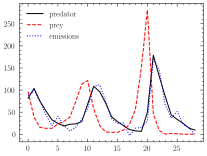

In [6]:
spn = SPN(state_dim, num_reactions, emission_dim, emission_function, input_dim)

key, subkey = jr.split(jr.PRNGKey(0))
params = sample_ssm_params(subkey, prior, 100)
key, subkey = jr.split(key)
dt_obs = 1.0
num_timesteps = 30
states, emissions = spn.simulate(subkey, params[0], dt_obs, num_timesteps)
plt.plot(states[:, 0], label = 'predator')
plt.plot(states[:, 1], label = 'prey')
plt.plot(emissions, label = 'emissions')
plt.legend()
plt.show()

## Old implementations

In [7]:
def gillespie_lotka_volterra(key, params, init_state, num_iters):
    S = jnp.array([[1, -1, 0], [0, 1, -1]]).T

    def step(carry, t):
        t_prev, state, key = carry
        state = jnp.maximum(state, 0.0)
        key, key_time, key_event = jr.split(key, 3)
        hazard_vals = jnp.array([params[0]*state[0], params[1]*state[0]*state[1], params[2]*state[1]])
        total_hazard = jnp.sum(hazard_vals)
        probs = hazard_vals/total_hazard
        dt = tfd.Exponential(total_hazard).sample(seed=key_time)
        t_next = t_prev + dt
        event = tfd.Categorical(probs).sample(seed=key_event)
        state = state + S[event]
        carry = t_next, state, key
        return carry, (t_next, state)

    carry = (0.0, init_state, key)
    out = lax.scan(step, carry, jnp.arange(num_iters))
    return out

In [8]:
log_rates = jnp.array([jnp.log(0.01), jnp.log(0.5), jnp.log(1), jnp.log(0.01)])

In [9]:
hazard_fn = lambda state, log_rates: jnp.array([jnp.exp(log_rates[0]) * state[0] * state[1],
                                                jnp.exp(log_rates[1]) * state[0],
                                                jnp.exp(log_rates[2]) * state[1],
                                                jnp.exp(log_rates[3]) * state[0] * state[1]])

S = jnp.array([[1, -1, 0, 0], [-1, 0, 1, -1]]).T
dt_obs = 1.0

def _step(carry, t):

    def _cond_fn(val):
        _, sumtime, _, _ = val
        return sumtime < dt_obs

    def _while_step(_):
        istate, sumtime, ireactions, key = _
        h = hazard_fn(istate, log_rates)
        h0 = jnp.sum(h)[None]
        key, subkey = jr.split(key)
        dt = tfd.Exponential(h0).sample(seed=subkey)

        prob_vec = h / h0
        key, subkey = jr.split(key)
        event = tfd.Categorical(probs=prob_vec).sample(seed=subkey)

        istate += S[event]
        istate = jnp.maximum(istate, 0.0)
        sumtime += dt[0]
        ireactions += 1
        
        return istate, sumtime, ireactions, key
    
    next_state, sumtime, ireactions, _ = lax.while_loop(_cond_fn, _while_step, carry)
    carry = (next_state, sumtime-dt_obs, ireactions, subkey)
    return carry, (next_state, sumtime)

num_obs = 30
# initial_mean = 1.0 * jnp.array([30, 5])
carry = (initial_mean, 0.0, 0, subkey)
out, (states, sumtime) = lax.scan(_step, carry, jnp.arange(num_obs))

plt.plot(jnp.arange(num_obs) * dt_obs, states[:, 0], label='x')
plt.plot(jnp.arange(num_obs) * dt_obs, states[:, 1], label='y')
plt.show()


NameError: name 'lax' is not defined